### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.model_selection import KFold
import zipfile

In [4]:
# Setup Mixed Precision

# Detect TPY
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'

policy = tf.keras.mixed_precision.Policy(policyConfig)
# tf.keras.mixed_precision.set_global_policy(policy)

### Load and process the (augmented) dataset

In [5]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X.astype('float32') / 255

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels])

9650
9650
4860
4790


In [6]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=seed, test_size=0.5, stratify=y_temp)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (6755, 96, 96, 3), y_train shape: (6755, 2)
X_val shape: (1447, 96, 96, 3), y_val shape: (1447, 2)


In [7]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 100


### Train the (sequential) model

In [8]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

In [ ]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

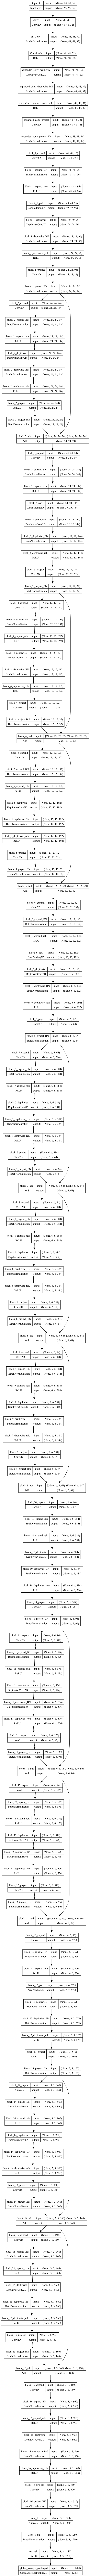

In [9]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [10]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='sigmoid')(x)  # Modifica del numero di neuroni

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Train the model

In [11]:
tl_history = tl_model.fit(
    x=preprocess_input(X_train * 255),
    y=y_train,
    batch_size=128,
    epochs=2000,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=200, restore_best_weights=True)]
).history

Epoch 1/2000
53/53 [==============================] - 7s 86ms/step - loss: 0.5850 - accuracy: 0.7014 - val_loss: 0.4985 - val_accuracy: 0.7657
Epoch 2/2000
53/53 [==============================] - 3s 50ms/step - loss: 0.4828 - accuracy: 0.7759 - val_loss: 0.4522 - val_accuracy: 0.8023
Epoch 3/2000
53/53 [==============================] - 2s 46ms/step - loss: 0.4485 - accuracy: 0.7969 - val_loss: 0.4340 - val_accuracy: 0.8086
Epoch 4/2000
53/53 [==============================] - 2s 45ms/step - loss: 0.4274 - accuracy: 0.8139 - val_loss: 0.4292 - val_accuracy: 0.7961
Epoch 5/2000
53/53 [==============================] - 2s 46ms/step - loss: 0.4156 - accuracy: 0.8163 - val_loss: 0.4133 - val_accuracy: 0.8141
Epoch 6/2000
53/53 [==============================] - 3s 49ms/step - loss: 0.4011 - accuracy: 0.8252 - val_loss: 0.4063 - val_accuracy: 0.8182
Epoch 7/2000
53/53 [==============================] - 3s 49ms/step - loss: 0.3923 - accuracy: 0.8305 - val_loss: 0.4021 - val_accuracy: 0.8210

### Validate the (sequential) model

In [12]:
tl_model.save('model_14-11-23')

# Define the RandomRotation layer
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.3),
])

# Define the RandomFlip layer
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

X_test_1 = X_val
X_test_2 = rotation(X_val)
X_test_3 = flip(X_val)

true_labels = y_val

# Make predictions on each test set
predictions_1 = tl_model.predict(X_test_1)
predictions_2 = tl_model.predict(X_test_2)
predictions_3 = tl_model.predict(X_test_3)

# Assuming binary classification, adjust if needed

best_accuracy_1 = 0.0
limit_1 = 0.0

for limit in range(100):
    predicted_labels_1 = (predictions_1 > (limit / 100.0)).astype(int)
    accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)

    if (accuracy_1 < best_accuracy_1):
        continue

    best_accuracy_1 = accuracy_1
    limit_1 = (limit / 100.0)

best_accuracy_2 = 0.0
limit_2 = 0.0

for limit in range(100):
    predicted_labels_2 = (predictions_2 > (limit / 100.0)).astype(int)
    accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)

    if (accuracy_2 < best_accuracy_2):
        continue

    best_accuracy_2 = accuracy_2
    limit_2 = (limit / 100.0)

best_accuracy_3 = 0.0
limit_3 = 0.0

for limit in range(100):
    predicted_labels_3 = (predictions_3 > (limit / 100.0)).astype(int)
    accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

    if (accuracy_3 < best_accuracy_3):
        continue

    best_accuracy_3 = accuracy_3
    limit_3 = (limit / 100.0)


print("Limit on Test Set 1:", limit_1)
print("Limit on Test Set 2:", limit_2)
print("Limit on Test Set 3:", limit_3)

predicted_labels_1 = (predictions_1 > limit_1).astype(int)
predicted_labels_2 = (predictions_2 > limit_2).astype(int)
predicted_labels_3 = (predictions_3 > limit_3).astype(int)

# Compare the results
accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

print("Accuracy on Test Set 1:", accuracy_1)
print("Accuracy on Test Set 2:", accuracy_2)
print("Accuracy on Test Set 3:", accuracy_3)


final_prediction = []

for i in range(len(predictions_1)):
    healthy_prediction = predicted_labels_1[i] + predicted_labels_2[i] + predicted_labels_3[i]

    if (healthy_prediction >= 2):
        final_prediction.append([1])

    else:
        final_prediction.append([0])

final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)

print("Accuracy of Final Prediction:", final_accuracy)

46/46 [==============================] - 1s 18ms/step
Limit on Test Set 1: 0.82
Limit on Test Set 2: 0.4
Limit on Test Set 3: 0.82
Accuracy on Test Set 1: 1.248790601243953
Accuracy on Test Set 2: 1.2785072563925364
Accuracy on Test Set 3: 1.239115411195577


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Predictions on Test Set 1:
[[0.04237992 0.975294  ]
 [0.9825753  0.03287944]
 [0.9748044  0.02580233]
 [0.96459895 0.03149185]
 [0.34620047 0.68334013]
 [0.65359885 0.22856943]
 [0.9771811  0.024052  ]
 [0.995644   0.00242358]
 [0.79347605 0.25722364]
 [0.8702282  0.10640758]]

Predictions on Test Set 2:
[[0.05693846 0.9319817 ]
 [0.78434676 0.20850894]
 [0.54140776 0.52255166]
 [0.22031647 0.67810494]
 [0.12666714 0.8298807 ]
 [0.8412983  0.1362658 ]
 [0.8953624  0.08915079]
 [0.9750676  0.01933093]
 [0.6968209  0.3699437 ]
 [0.8116658  0.17666307]]

Predictions on Test Set 3:
[[0.6666434  0.29885924]
 [0.9799958  0.03468649]
 [0.9748044  0.02580233]
 [0.96459895 0.03149185]
 [0.31836963 0.7438783 ]
 [0.49248597 0.35886943]
 [0.9771811  0.024052  ]
 [0.995644   0.00242358]
 [0.8611581  0.1346338 ]
 [0.9205813  0.07319353]]

Final Predictions:
[]


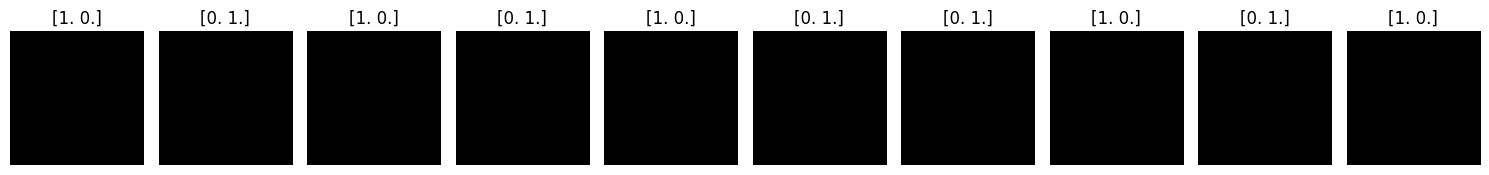

In [13]:
# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]
    ax.imshow(X_val[i].astype(np.uint8))
    ax.set_title(y_val[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


### Plot the training

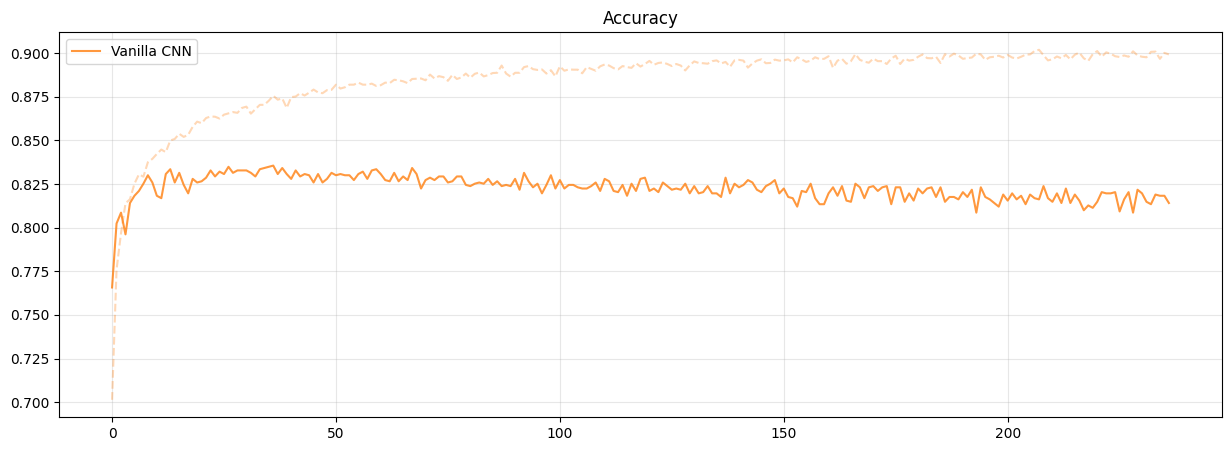

In [14]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the model and create submission

In [18]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
tl_model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        # Define the RandomRotation layer
        rotation = tf.keras.Sequential([
            tfkl.RandomRotation(0.3),
        ])

        # Define the RandomFlip layer
        flip = tf.keras.Sequential([
            tfkl.RandomFlip("vertical"),
        ])

        limit = tf.constant(0.56, dtype=tf.float32)

        X_test_1 = X
        X_test_2 = rotation(X) 
        X_test_3 = flip(X)

        out1 = self.model.predict(X_test_1)
        out2 = self.model.predict(X_test_2)
        out3 = self.model.predict(X_test_3)

        out1 = tf.argmax(out1, axis=-1)  # Shape [BS]
        out2 = tf.argmax(out2, axis=-1)  # Shape [BS]
        out3 = tf.argmax(out3, axis=-1)  # Shape [BS]
        
        out = []  # Initialize out as an empty list
        
        for i in range(len(out1)):
            hp = 0
        
            if tf.cast(out1[i], tf.float32) > limit:
                hp += 1
        
            if tf.cast(out2[i], tf.float32) > limit:
                hp += 1
        
            if tf.cast(out3[i], tf.float32) > limit:
                hp += 1
        
            if hp >= 2:
                out.append([1])
            else:
                out.append([0])

        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)
            
            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue
        
            # print(foldername)
            print(file_path)
            
            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)


SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231114_224357.zip
